# Extending the Hierarchy: Subjects Within Categories
### Baseball batting abilities by position

The book focuses on example data collected for the 2012 MLB season. To get some practice I am going to rebuild the 2012 experiment using data from the 2018 regular MLB season

Reference: https://www.baseball-reference.com/leagues/MLB/2018-standard-batting.shtml

## Data Description
---
The data is sourced from `./data/2018-standard-batting.csv` and then stripped to only contain the features available in the books presentation.

We have also eliminated all players with 0 AtBats

The columns retained are:

1. Player
2. Primary Position
3. Hits
4. AtBats

### Player Position Chart
---
Source: https://en.wikipedia.org/wiki/Baseball_positions

![alt text](./img/660px-Baseball_positions.svg.png "Player position chart")

Just as for the original analysis, for simplicity we will reduce all positions played to consider only the primary position for each player.

In [11]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

### Load Baseball Data

As a first pass approximation I will be using the 2012 data to build out all required charts. I will then do a reverse pass to clean and load the 2018 data.

In [2]:
df = pd.read_csv('data/2012-mlb-standard-batting.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null category
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: category(1), int64(2), object(1)
memory usage: 23.7+ KB


In [3]:
# Compute batting average
df['BatAv'] = df.Hits.divide(df.AtBats)
df.head(10)

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186
5,Nathan Adcock,Pitcher,0,1,0.000000
6,Jeremy Affeldt,Pitcher,0,1,0.000000
7,Brandon Allen,1st Base,2,20,0.100000
8,Yonder Alonso,1st Base,150,549,0.273224
9,Jose Altuve,2nd Base,167,576,0.289931


In [4]:
# Batting average by primary field positions calculated from the data
df.groupby('PriPos')['Hits', 'AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

In [5]:
pripos_idx = df.PriPos.cat.codes.values # Convert categorical naming to coded integers
pripos_codes = df.PriPos.cat.categories # Retrieve member categories in the set of primary positions
num_pripos = pripos_codes.size
num_players = df.index.size # Our dataset has 1 player per row

In [6]:
with pm.Model() as baseball_model:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Categorical parameters
    omega_c = pm.Beta('omega_c',
                      omega * (kappa - 2) + 1,
                      (1 - omega) * (kappa - 2) + 1,
                      shape=num_pripos)
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2', 0.01, 0.01, shape=num_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
    
    # Player parameters
    theta = pm.Beta('theta',
                    omega_c[pripos_idx] * (kappa_c[pripos_idx] - 2) + 1,
                    (1 - omega_c[pripos_idx]) * (kappa_c[pripos_idx] - 2) + 1,
                    shape=num_players)
    
    y = pm.Binomial('y', n=df.AtBats.values, p=theta, observed=df.Hits)
    

In [ ]:
with baseball_model:
    trace = pm.sample(11000, cores=6)

In [11]:
#pm.save_trace(trace, 'baseball_model_2018.trace')

'baseball_model_2018.trace'

In [7]:
#with baseball_model:
#    trace = pm.load_trace('baseball_model.trace')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4019fa898>,
      dtype=object)

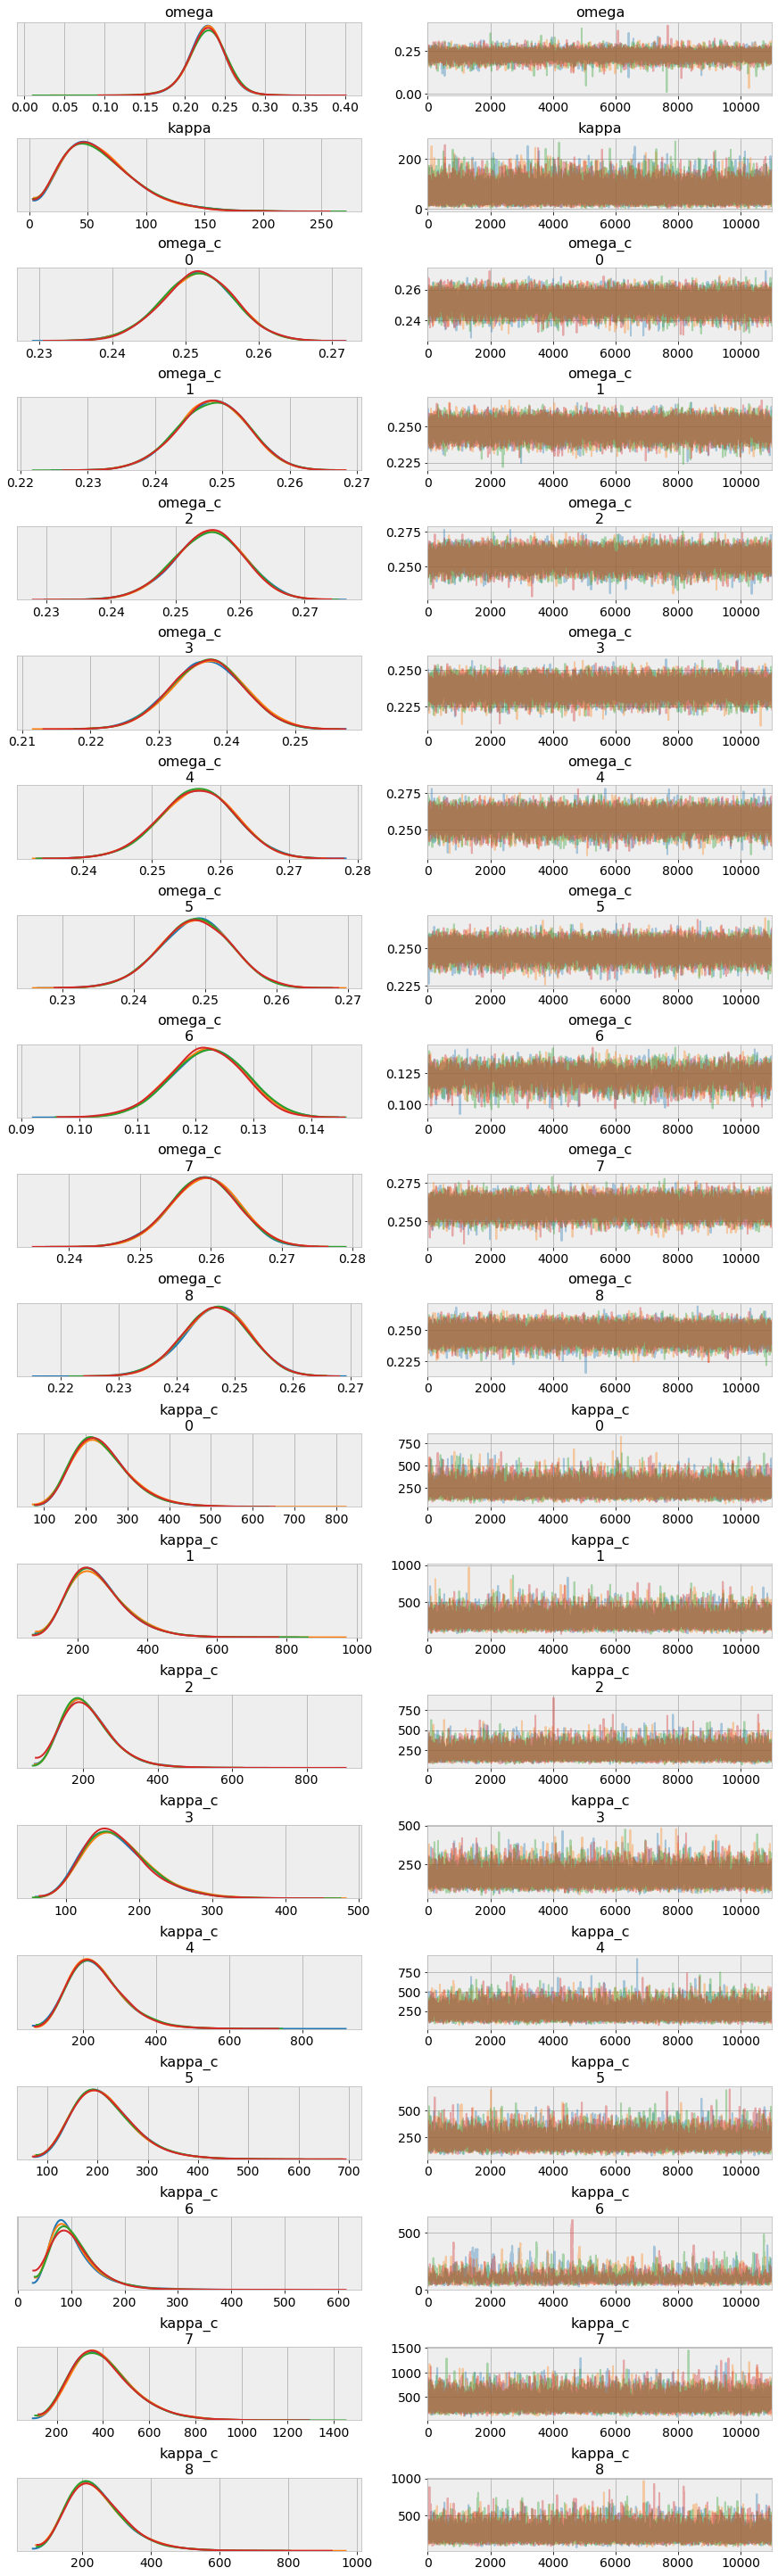

In [10]:
pm.traceplot(trace, ['omega', 'kappa', 'omega_c', 'kappa_c'])

#### Posterior distribution of hyper parameter omega after sampling

Text(0.5, 0, 'omega')

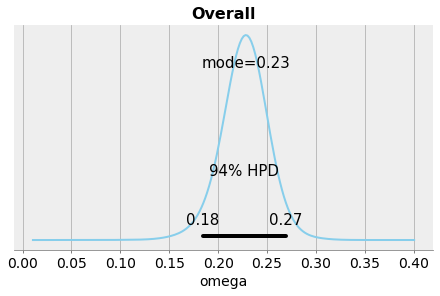

In [8]:
color = '#87ceeb'
pm.plot_posterior(trace['omega'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14})

Text(0.5, 0, 'kappa')

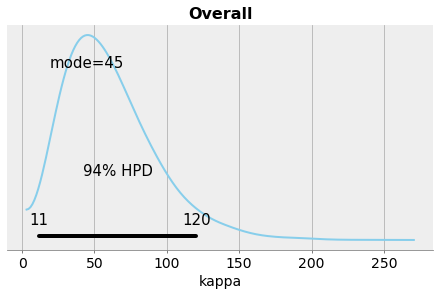

In [18]:
color = '#87ceeb'
pm.plot_posterior(trace['kappa'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('kappa', fontdict={'fontsize':14})

#### Posterior distributions of the omega_c parameters after sampling

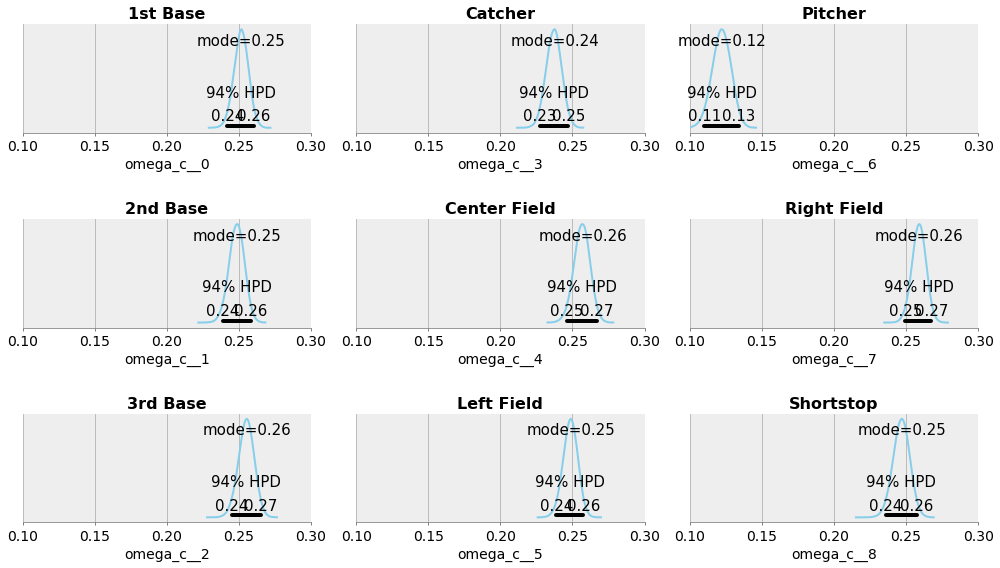

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(14, 8))

for i, ax in enumerate(axes.T.flatten()):
    pm.plot_posterior(trace['omega_c'][:,i], ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)
    
plt.tight_layout(h_pad=3)

### Reproduce Fig 9.14

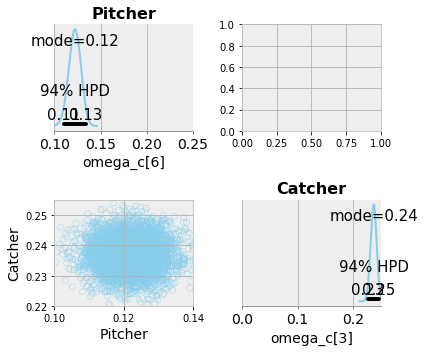

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5))

font_d = {'size':14}

# omega posterior plots
pm.plot_posterior(trace['omega_c'][:,6], point_estimate='mode', ax=axes[0, 0], color=color)
axes[0, 0].set_title(pripos_codes[6], fontdict={'fontsize':16, 'fontweight':'bold'})
axes[0, 0].set_xlabel('omega_c[{}]'.format(6), fontdict=font_d)
axes[0, 0].set(xlim=(0.1,0.25))

pm.plot_posterior(trace['omega_c'][:,3], point_estimate='mode', ax=axes[1, 1], color=color)
axes[1, 1].set_title(pripos_codes[3], fontdict={'fontsize':16, 'fontweight':'bold'})
axes[1, 1].set_xlabel('omega_c[{}]'.format(3), fontdict=font_d)
axes[1, 1].set(xlim=(0,0.25))

# omega scatter plot
axes[1, 0].scatter(trace['omega_c'][::10,6], trace['omega_c'][::10,3], alpha=0.75, color=color, facecolor='none')
axes[1, 0].plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
axes[1, 0].set_xlabel(pripos_codes[6], fontdict=font_d)
axes[1, 0].set_ylabel(pripos_codes[3], fontdict=font_d)
axes[1, 0].set(xlim=(0.1,0.14), ylim=(0.22,0.255))

    
plt.tight_layout(h_pad=3)